Bài 4 : Text classification: huấn luyện một RNN nhận xét một bình luận là tích cực hay tiêu cực.

https://www.tensorflow.org/text/tutorials/text_classification_rnn


In [3]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [4]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to C:\Users\OS\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [6]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Documentaries of this kind are often very opinionated. This film seems to take all opinions out and let the viewer decide what to do with the information provided. It is sad the conditions these poor people have to work in, this film does a great job of showing the ugly side of sweat shops. The film Mardi Gras: Made in China was a good way of showing the world how something as petty as beads for a celebration can effect the lives of so many people in another country.<br /><br />I had to watch this film for an English class where we spent our time talking about sweat shops and how some people are trying to eliminate them and this film helped get the topic rolling. It was a great, very informative movie and I'd recommend anyone see it, it kinda opens your eyes."
 b'Story about four teenage girls growing up in California. Jeanie (Jodie Foster) is the most level-headed of the bunch--but wants to move out of her house where she lives with her divorced mother (Sally Kellerman). An

In [ ]:
#Tạo bộ mã hoá văn bản
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   5,  11, ...,   0,   0,   0],
       [ 64,  43, 709, ...,   0,   0,   0],
       [  3,   9,   7, ...,   0,   0,   0]], dtype=int64)

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Documentaries of this kind are often very opinionated. This film seems to take all opinions out and let the viewer decide what to do with the information provided. It is sad the conditions these poor people have to work in, this film does a great job of showing the ugly side of sweat shops. The film Mardi Gras: Made in China was a good way of showing the world how something as petty as beads for a celebration can effect the lives of so many people in another country.<br /><br />I had to watch this film for an English class where we spent our time talking about sweat shops and how some people are trying to eliminate them and this film helped get the topic rolling. It was a great, very informative movie and I'd recommend anyone see it, it kinda opens your eyes."
Round-trip:  [UNK] of this kind are often very [UNK] this film seems to take all [UNK] out and let the viewer [UNK] what to do with the [UNK] [UNK] it is sad the [UNK] these poor people have to work in this film does

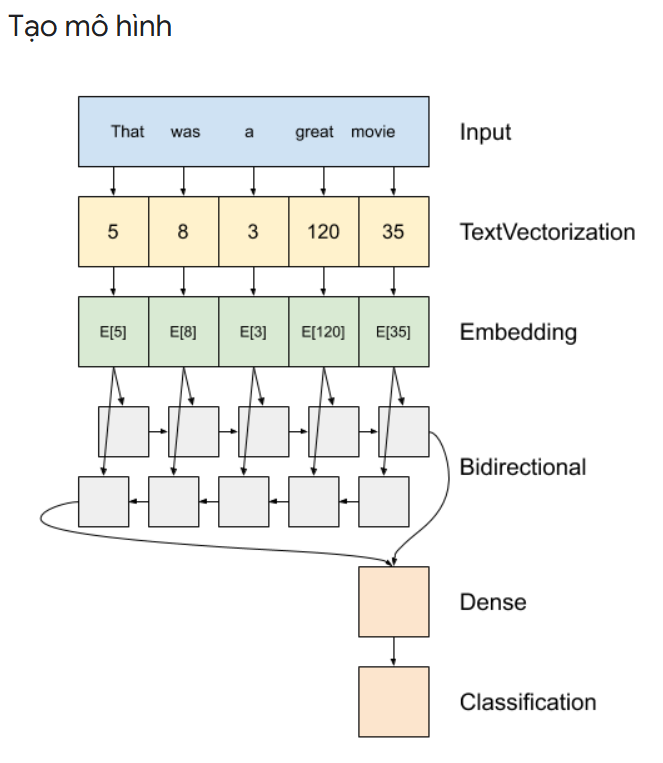

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [20]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

ValueError: Invalid dtype: str3328